In [57]:
import numpy as np
import os
import pandas as pd
import sys
import torch
import pathlib

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [58]:
sys.path.append(os.path.join(sys.path[0], '../..'))

import endure.lsm.cost_model as Cost
from endure.lsm.solver import EndureLevelSolver
from endure.data.io import Reader
from endure.ltune.data.generator import LTuneGenerator
from endure.ltune.model.builder import LTuneModelBuilder
from endure.ltune.loss import LearnedCostModelLoss
from endure.lcm.model.builder import LearnedCostModelBuilder

# Loading Model

In [59]:
path = '/data/models/level-tuner-03-24-v1/'
config = Reader.read_config(os.path.join(path, 'endure.toml'))
data_generator = LTuneGenerator(config)
cf = Cost.EndureLevelCost(config)
solver = EndureLevelSolver(config)

In [60]:
model = LTuneModelBuilder(config).build_model()
model_name = os.path.join(path, 'best.model')
# model_name = os.path.join(path, 'checkpoints/epoch_30.checkpoint')
model_data = torch.load(model_name)
model_params = model_data['model_state_dict'] if model_name.endswith('checkpoint') else model_data
status = model.load_state_dict(model_params)
status

<All keys matched successfully>

# Loading Learned Cost Model

In [61]:
loss_path, loss_name = os.path.split(config['job']['LTuneTrain']['loss_fn_path'])
loss_path = os.path.join(config['io']['data_dir'], loss_path)
loss_config = Reader.read_config(os.path.join(loss_path, 'endure.toml'))

builder = LearnedCostModelBuilder(loss_config)
loss = builder.build_model()
loss_name = os.path.join(loss_path, loss_name)
# loss_name = os.path.join(loss_path, 'checkpoints/epoch_20.checkpoint')
loss_data = torch.load(loss_name)
loss_params = loss_data['model_state_dict'] if loss_name.endswith('checkpoint') else loss_data
load_status = loss.load_state_dict(loss_params)
loss.eval()
load_status

<All keys matched successfully>

In [62]:
def sanitize_inputs(inputs: np.array):
    cont_inputs = (inputs[0:5] - config['lcm']['data']['mean_bias'])
    cont_inputs /= config['lcm']['data']['std_bias']
    
    cate_inputs = inputs[5:]
    cate_inputs[0] -= config['lsm']['size_ratio']['min']
    if len(cate_inputs) > 1:
        cate_inputs[1:] -= config['lsm']['size_ratio']['min'] - 1
    
    return np.concatenate((cont_inputs, cate_inputs))

In [63]:
def cost_func_learned_raw_eval(args, wl):
    h, T = args
    z0, z1, q, w = wl
    inputs = sanitize_inputs(np.array([z0, z1, q, w, h, T], np.float32))
    inputs = torch.from_numpy(inputs.reshape(1, -1)).float()
    with torch.no_grad():
        pred = loss(inputs)
        pred = pred.sum().item()
    return pred

# Training Loss

In [64]:
config['job']['LTuneTrain']

{'max_epochs': 50,
 'save_dir': 'models/level-tuner-03-24-v1',
 'use_gpu_if_avail': True,
 'loss_fn_path': 'models/level-03-14-v1/best.model',
 'optimizer': 'Adam',
 'lr_scheduler': 'CosineAnnealing',
 'train': {'dir': 'train-data/workload-parquet',
  'format': 'parquet',
  'batch_size': 8192,
  'shuffle': True,
  'num_workers': 6,
  'drop_last': True,
  'use_dp': False},
 'test': {'dir': 'test-data/workload-parquet',
  'format': 'parquet',
  'batch_size': 262114,
  'shuffle': False,
  'num_workers': 1,
  'drop_last': True,
  'use_dp': False}}

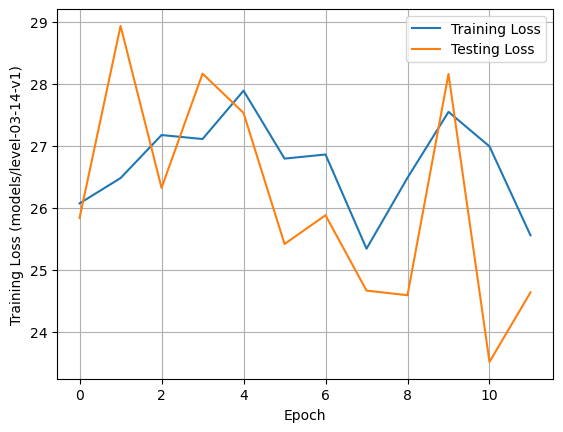

In [65]:
losses = pd.read_csv(os.path.join(path, 'losses.csv'))
fig, ax = plt.subplots()
ax.plot(losses['epoch'], losses['train_loss'], label='Training Loss')
ax.plot(losses['epoch'], losses['test_loss'], label='Testing Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel(f'Training Loss ({os.path.dirname(config["job"]["LTuneTrain"]["loss_fn_path"])})')
ax.set_title(f'{os.path.basename(path)}')
ax.grid()
_ = ax.legend()

[4] - [51 x 32] - [51]

# Evaluation

In [66]:
def model_out_to_design(output):
    h = output[:, 0].item()
    size_ratio = torch.argmax(output[:, 1:]).item()
    return np.array([h, size_ratio + config['lsm']['size_ratio']['min']])

In [67]:
def eval_rand_workloads():
    WORKLOADS = 1000
    df = []
    workloads = data_generator.generate_workloads(WORKLOADS)
    for wl in tqdm(workloads):
        wl = np.array(wl)
        z0, z1, q, w = wl
        
        # eval normal
        stune_h, stune_T = solver.find_nominal_design(z0, z1, q, w).x
        stune_T = np.ceil(stune_T)
        stune_h = np.around(stune_h, 3)
        stune_pred = torch.Tensor([stune_h, stune_T - 2]).view(1, -1)
        stune_loss = cost_func_learned_raw_eval([stune_h, stune_T], wl)
        stune_cost = cf(stune_h, stune_T, z0, z1, q, w)
        stune_level = cf.cf.L(stune_h, stune_T, True)
        
        # eval learned
        x = torch.Tensor((z0, z1, q, w)).view(1, -1)
        ltune_h, ltune_T = model_out_to_design(model(x, hard=True))
        ltune_pred = torch.Tensor([ltune_h, ltune_T - 2]).view(1, -1)
        ltune_loss = cost_func_learned_raw_eval([ltune_h, ltune_T], wl)
        ltune_cost = cf(ltune_h, ltune_T, z0, z1, q, w)
        ltune_level = cf.cf.L(ltune_h, ltune_T, True)
        
        row = {
            'z0': z0,
            'z1': z1,
            'q': q,
            'w': w,
            'stune_h': stune_h,
            'stune_T': stune_T,
            'stune_cost': stune_cost,
            'stune_loss': stune_loss,
            'stune_level': stune_level,
            'ltune_h': ltune_h,
            'ltune_T': ltune_T,
            'ltune_cost': ltune_cost,
            'ltune_loss': ltune_loss,
            'ltune_level': ltune_level,
        }
        df.append(row)
    
    return pd.DataFrame(df)

In [68]:
np.random.seed(0)
df = eval_rand_workloads()
df['delta_cost'] = (df['stune_cost'] - df['ltune_cost']) / df['stune_cost']
df['delta_loss'] = (df['stune_loss'] - df['ltune_loss']) / df['stune_loss']
df['stune_diff'] = (df['stune_cost'] - df['stune_loss'])
df['ltune_diff'] = (df['ltune_cost'] - df['ltune_loss'])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [69]:
df.sort_values(by='ltune_h', ascending=False).head(20)

,z0,z1,q,w,stune_h,stune_T,stune_cost,stune_loss,stune_level,ltune_h,ltune_T,ltune_cost,ltune_loss,ltune_level,delta_cost,delta_loss,stune_diff,ltune_diff
213,0.745,0.103,0.088,0.064,6.352,7.0,0.975952,0.969188,4.0,4.898788,35.0,1.551674,1.558858,3.0,-0.589909,-0.608416,0.006764,-0.007184
344,0.719,0.225,0.021,0.035,7.652,6.0,0.597530,0.617272,5.0,4.880583,46.0,1.123586,1.124726,2.0,-0.880383,-0.822093,-0.019741,-0.001140
880,0.689,0.106,0.159,0.046,5.834,11.0,1.107925,1.107768,4.0,4.877245,12.0,1.119029,1.109216,3.0,-0.010022,-0.001307,0.000157,0.009813
419,0.694,0.088,0.134,0.084,5.754,8.0,1.288428,1.280721,4.0,4.873442,44.0,2.258779,2.259007,2.0,-0.753128,-0.763856,0.007708,-0.000228
952,0.752,0.065,0.133,0.050,6.089,10.0,1.013482,1.009466,4.0,4.867072,47.0,1.559246,1.573505,2.0,-0.538505,-0.558751,0.004016,-0.014259
149,0.905,0.064,0.016,0.015,8.365,7.0,0.279450,0.314839,5.0,4.859732,14.0,0.375517,0.387473,3.0,-0.343771,-0.230701,-0.035389,-0.011956
268,0.709,0.100,0.145,0.046,5.964,11.0,1.055703,1.060337,4.0,4.848223,27.0,1.236898,1.245088,3.0,-0.171635,-0.174237,-0.004634,-0.008189
208,0.765,0.125,0.086,0.024,6.798,12.0,0.685887,0.677646,4.0,4.833438,39.0,0.875309,0.868099,3.0,-0.276169,-0.281052,0.008242,0.007209
283,0.516,0.221,0.152,0.111,5.131,7.0,1.655342,1.657235,4.0,4.832583,31.0,2.490669,2.494054,3.0,-0.504625,-0.504949,-0.001893,-0.003385
157,0.634,0.233,0.076,0.057,6.354,7.0,0.999554,0.989133,4.0,4.813752,9.0,1.032999,1.038879,4.0,-0.033461,-0.050292,0.010420,-0.005880


## Analytical Cost Model

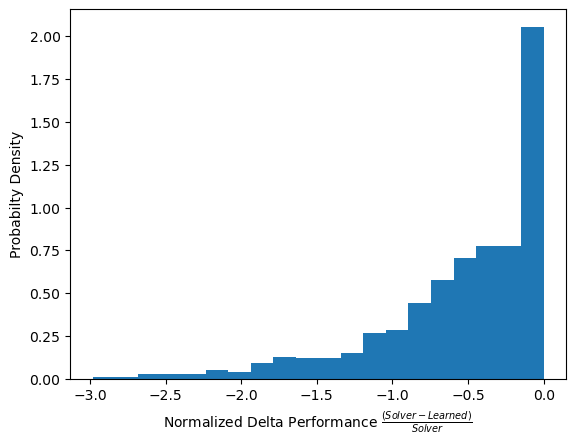

In [70]:
fig, ax = plt.subplots()
ax.hist(df['delta_cost'], bins=20, density=True)
ax.set_ylabel('Probabilty Density')
ax.set_xlabel('Normalized Delta Performance $\\frac{(Solver - Learned)}{Solver}$')
plt.show()

## Learned Cost Model

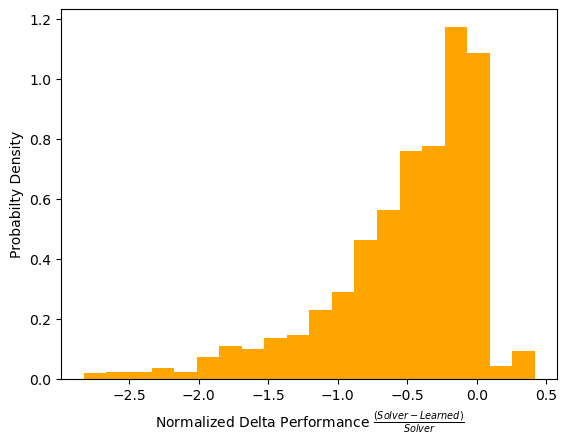

In [71]:
fig, ax = plt.subplots()
ax.hist(df['delta_loss'], bins=20, density=True, color='orange')
ax.set_ylabel('Probabilty Density')
ax.set_xlabel('Normalized Delta Performance $\\frac{(Solver - Learned)}{Solver}$')
plt.show()

## Difference in ACM and LCM

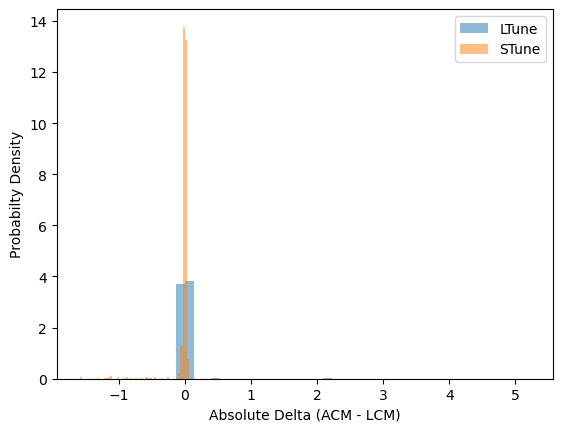

In [72]:
fig, ax = plt.subplots()
ax.hist(df['ltune_diff'], bins=50, alpha=0.5, density=True, label='LTune')
ax.hist(df['stune_diff'], bins=50, alpha=0.5, density=True, label='STune')
ax.set_ylabel('Probabilty Density')
ax.set_xlabel('Absolute Delta (ACM - LCM)')
ax.legend()
plt.show()